In [1]:
# %qtconsole

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# %qtconsole

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)
			
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')
import pickle
from pdpbox import pdp, info_plots

In [2]:
from datetime import datetime, timedelta 
from dateutil.relativedelta import relativedelta

# Load data and pre-process

In [3]:
# url = r'https://raw.githubusercontent.com/klin059/Auckland_traffic_analysis/master/data/merged_data_20190728.csv'
url = r'data/merged_data_20190728.csv'

In [4]:
df_orig = pd.read_csv(url, parse_dates = ['count_date'])
df = df_orig.copy()
df.sort_values(by = "count_date", inplace = True)
df.head()
df.tail()

,carr_way_no,road_id,road_name,start_name,end_name,location,latest,count_date,adt,latitude,longitude,cway_width,traff_manage_level,Shape__Length
4682,12411.0,40986,COLWILL RD,SPARGO RD,END,1704.0,No,1974-07-12,125.0,-36.832191,174.636777,6.8,"< 10,000 vpd Rural/<15,000 vpd Urban",396.674078
11389,13617.0,40854,GLORIA AVE,OLD TE ATATU RD,GRAHAM AVE,99.0,No,1974-08-11,1823.0,-36.848907,174.650109,11.2,"< 10,000 vpd Rural/<15,000 vpd Urban",113.001344
65,10376.0,40798,HOBSONVILLE RD,LUCKENS RD,WESTPARK DR,1517.0,No,1974-08-11,2163.0,-36.814264,174.630139,9.0,">= 15,000 vpd Urban road, low speed",581.914617
49,10308.0,40798,HOBSONVILLE RD,MOTORWAY OVERBRIDGE (EAST ABUTMENT),OREIL AVE,158.0,No,1974-08-11,3900.0,-36.818091,174.615882,28.0,">= 15,000 vpd Urban road, low speed",199.169213
12333,11261.0,40365,TAIKATA RD,TE ATATU RD RAB,PEACHGROVE RD,30.0,No,1974-08-11,2490.0,-36.841192,174.651345,10.1,"< 10,000 vpd Rural/<15,000 vpd Urban",131.001559


,carr_way_no,road_id,road_name,start_name,end_name,location,latest,count_date,adt,latitude,longitude,cway_width,traff_manage_level,Shape__Length
22943,11585.0,40522,POMARIA RD,KINGDALE RD,LONGBURN RD,448.0,Yes,2019-03-06,6994.0,-36.861600,174.623820,8.6,"< 10,000 vpd Rural/<15,000 vpd Urban",185.273683
22964,13123.0,40909,FAIRDENE AVE,STEPHEN AVE,EDWARDS AVE,308.0,Yes,2019-03-06,3089.0,-36.865612,174.626350,7.5,"< 10,000 vpd Rural/<15,000 vpd Urban",337.605067
22942,11330.0,40389,STEPHEN AVE,POMARIA RD,KONA CRES (NORTH),107.0,Yes,2019-03-06,828.0,-36.863331,174.627693,7.0,<500 vpd (Low Volume),196.603260
22945,11747.0,40624,MILDMAY RD,HARRINGTON RD (AT TEE),LARISSA AVE,215.0,Yes,2019-03-06,294.0,-36.861519,174.617166,6.8,<500 vpd (Low Volume),175.769275
22952,12107.0,40823,HARRINGTON RD,HARRY WARD PL,ASCOT AVE,215.0,Yes,2019-03-06,1568.0,-36.859423,174.619489,7.0,"< 10,000 vpd Rural/<15,000 vpd Urban",113.234506


In [5]:
# # consider only traffic counts after 2010
# df.shape
df = df[df['count_date'] > pd.to_datetime('2009-12-31')]

In [6]:
import re
def add_datepart(df, fldname, drop=False, time=False, errors="raise"):	

    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Dayofyear', 'Week', 'Year', 'Month', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
#     , , 'Day',''Dayofweek''
#             'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [7]:
df.head()

,carr_way_no,road_id,road_name,start_name,end_name,location,latest,count_date,adt,latitude,longitude,cway_width,traff_manage_level,Shape__Length
2020,6933.0,20038,HURSTMERE RD,MINNEHAHA AVE,KITCHENER RD,1315.0,No,2010-01-04,11946.0,-36.777666,174.775108,12.6,">= 15,000 vpd Urban road, low speed",254.802502
3319,6681.0,20001,EAST COAST RD (TAKA/GLENFIELD/E.C,SPENCER RD,JOHN DOWNS DR,8046.0,No,2010-01-04,10089.0,-36.720712,174.724027,13.4,">= 15,000 vpd Urban road, low speed",820.181010
1176,6745.0,20011,GLENFIELD RD,SPEEDY CRES,CORONATION RD,1046.0,No,2010-01-04,16507.0,-36.794472,174.723897,13.0,">= 15,000 vpd Urban road, low speed",426.472519
944,6701.0,20002,LAKE RD (DEVONPORT),BARDIA ST,EVERSLEIGH RD,2623.0,No,2010-01-04,23655.0,-36.802798,174.787569,12.0,">= 15,000 vpd Urban road, low speed",529.999614
4330,8486.0,22135,MOKOIA RD,ROSEBERRY AVE,BALMAIN RD,1261.0,No,2010-01-04,17588.0,-36.810808,174.712481,12.5,">= 15,000 vpd Urban road, low speed",427.289597


In [8]:
# encode cat columns
from sklearn.preprocessing import LabelEncoder
cat_cols = ['carr_way_no', 'road_id', 'road_name', 'start_name', 'end_name', 
            'location', 'latest', 'traff_manage_level']
label_encoders_dict = {}
for col in cat_cols:
    new_le = LabelEncoder()
    df[col] = new_le.fit_transform(df[col])
    label_encoders_dict[col] = new_le
display_all(df.head())

,carr_way_no,road_id,road_name,start_name,end_name,location,latest,count_date,adt,latitude,longitude,cway_width,traff_manage_level,Shape__Length
2020,1803,764,1378,2281,2120,1269,0,2010-01-04,11946.0,-36.777666,174.775108,12.6,3,254.802502
3319,1676,733,814,3359,1960,3291,0,2010-01-04,10089.0,-36.720712,174.724027,13.4,3,820.181010
1176,1712,741,1075,3356,847,1024,0,2010-01-04,16507.0,-36.794472,174.723897,13.0,3,426.472519
944,1686,734,1627,256,1270,2105,0,2010-01-04,23655.0,-36.802798,174.787569,12.0,3,529.999614
4330,2235,1072,1982,3076,279,1220,0,2010-01-04,17588.0,-36.810808,174.712481,12.5,3,427.289597


In [9]:
label_encoders_dict['traff_manage_level'].inverse_transform([0,1,2,3,4,5,6,7])

array(['< 10,000 vpd Rural/<15,000 vpd Urban', '<500 vpd (Low Volume)',
       '>= 10,000 vpd Rural/>=15,000 vpd Urban',
       '>= 15,000 vpd Urban road, low speed', '>=10,000 vpd & high speed',
       'Low volume < 250 vpd with low risk', 'State Highway', 'Unknown'],
      dtype=object)

In [10]:
# one hot encode traff_manage_level
df = pd.get_dummies(df, prefix_sep = "__", columns = ['traff_manage_level'])
df.columns

Index(['carr_way_no', 'road_id', 'road_name', 'start_name', 'end_name',
       'location', 'latest', 'count_date', 'adt', 'latitude', 'longitude',
       'cway_width', 'Shape__Length', 'traff_manage_level__0',
       'traff_manage_level__1', 'traff_manage_level__2',
       'traff_manage_level__3', 'traff_manage_level__4',
       'traff_manage_level__5', 'traff_manage_level__6',
       'traff_manage_level__7'],
      dtype='object')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17826 entries, 2020 to 22952
Data columns (total 21 columns):
carr_way_no              17826 non-null int64
road_id                  17826 non-null int64
road_name                17826 non-null int32
start_name               17826 non-null int32
end_name                 17826 non-null int32
location                 17826 non-null int64
latest                   17826 non-null int32
count_date               17826 non-null datetime64[ns]
adt                      17826 non-null float64
latitude                 17826 non-null float64
longitude                17826 non-null float64
cway_width               17826 non-null float64
Shape__Length            17826 non-null float64
traff_manage_level__0    17826 non-null uint8
traff_manage_level__1    17826 non-null uint8
traff_manage_level__2    17826 non-null uint8
traff_manage_level__3    17826 non-null uint8
traff_manage_level__4    17826 non-null uint8
traff_manage_level__5    17826 non-null u

In [12]:
add_datepart(df, 'count_date')

# Model fitting

In [13]:
from sklearn.ensemble import RandomForestRegressor
import math
from sklearn.utils import shuffle
def split_vals(df, n):
    return df[:n].copy(), df[n:].copy()

def rmse(x,y): 
    # calculates r^2
    return math.sqrt(np.square(np.subtract(x,y)).mean())
def get_scores(m, X_train, X_valid, y_train, y_valid):
    # returns rmsq training, r^2 validation, avg accuracy training, avg accuracy validation, oob
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): 
        res.append(m.oob_score_)
    return res

def train_test_split(df, xcols, ycol, train_size_f = 0.75, shuffle_bool = False):
    train_size = int(df.shape[0] * train_size_f)
    if shuffle_bool:
        df_model = shuffle(df)
    else:
        df_model = df.copy()
    X, y = df_model[xcols], df_model[ycol]
    X_train, X_test = split_vals(X, train_size)
    y_train, y_test = split_vals(y, train_size)
    return X_train, X_test, y_train, y_test

def tt_split_by_years(df, xcols, ycol, train_years = [2016, 2017, 2018], test_years = [2019]):
#     train-test split by year
    df_train = df[df.count_Year.isin(train_years)]
    df_test = df[df.count_Year.isin(test_years)]
    X_train, X_test = df_train[xcols], df_test[xcols]
    y_train, y_test = df_train[ycol], df_test[ycol]
    return X_train, X_test, y_train, y_test

def split_by_forward_period(df, xcols, ycol, split_date = '2018-12-31', train_months = 36, test_months = 3):
#     walk forward train-test split
    d = pd.to_datetime(split_date)
    train_lb = d - relativedelta(months = train_months)
    test_ub = d + relativedelta(months = test_months)
    df_train = df[(df.count_date >= train_lb)&(df.count_date < d)]
    df_test = df[(df.count_date >= d)&(df.count_date < test_ub)]
    X_train, X_test = df_train[xcols], df_test[xcols]
    y_train, y_test = df_train[ycol], df_test[ycol]
    return X_train, X_test, y_train, y_test

def expanding_window_split(df, xcols, ycol, split_date = '2018-01-01', test_months = 2):
    # expanding window split
    d = pd.to_datetime(split_date)
    test_ub = d + relativedelta(months = test_months)
    df_train = df[df.count_date < d]
    df_test = df[(df.count_date >= d)&(df.count_date < test_ub)]
    X_train, X_test = df_train[xcols], df_test[xcols]
    y_train, y_test = df_train[ycol], df_test[ycol]
    return X_train, X_test, y_train, y_test

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)
def plot_fi(fi): 
    # fi is a dataframe
    # plot top 10 fi: plot_fi(rf_feat_importance(m, df_trn2)[:10])
    return fi.plot('cols','imp','barh', figsize=(12,7), legend=False)

In [14]:
df.columns

Index(['carr_way_no', 'road_id', 'road_name', 'start_name', 'end_name',
       'location', 'latest', 'count_date', 'adt', 'latitude', 'longitude',
       'cway_width', 'Shape__Length', 'traff_manage_level__0',
       'traff_manage_level__1', 'traff_manage_level__2',
       'traff_manage_level__3', 'traff_manage_level__4',
       'traff_manage_level__5', 'traff_manage_level__6',
       'traff_manage_level__7', 'count_Dayofyear', 'count_Week', 'count_Year',
       'count_Month', 'count_Is_month_end', 'count_Is_month_start',
       'count_Is_quarter_end', 'count_Is_quarter_start', 'count_Is_year_end',
       'count_Is_year_start', 'count_Elapsed'],
      dtype='object')

In [15]:
xcols = [col for col in df.columns]
xcols.remove('adt')
xcols.remove('road_name')
xcols.remove('count_date')
xcols.remove('latest')
ycol = 'adt'

## sliding window or expanding window split

In [17]:
# try sliding window split for the testing set
X_train, X_test, y_train, y_test = split_by_forward_period(df, xcols, ycol, split_date = '2018-05-31', train_months = 36, test_months = 2)
m = RandomForestRegressor(n_estimators=300, max_depth=28, max_features=0.5, oob_score= True, random_state=1, n_jobs  = -1)
m.fit(X_train, y_train)
get_scores(m, X_train, X_test, y_train, y_test)
# m.score(X_train, y_train)
# m.score(X_test, y_test)
# m.oob_score_
# rf_feat_importance(m, X_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=28,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=True, random_state=1, verbose=0, warm_start=False)

[1056.08629769755,
 4615.050130968227,
 0.9927399704362636,
 0.7198623741925434,
 0.9473770599010185]

In [18]:
# try expanding window split
X_train, X_test, y_train, y_test = expanding_window_split(df, xcols, ycol, split_date = '2018-05-31', test_months = 2)
m = RandomForestRegressor(n_estimators=300, max_depth=28, max_features=0.5, oob_score= True, random_state=1, n_jobs  = -1)
m.fit(X_train, y_train)
get_scores(m, X_train, X_test, y_train, y_test)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=28,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=True, random_state=1, verbose=0, warm_start=False)

[821.4664352633803,
 4503.942253645377,
 0.9965181228659281,
 0.7331886961522794,
 0.9747351274855336]

- Expanding window split performs better than sliding window split, use expanding window split.
- Note that the parameters of the random forest model are manually tuned.

## Feature selection

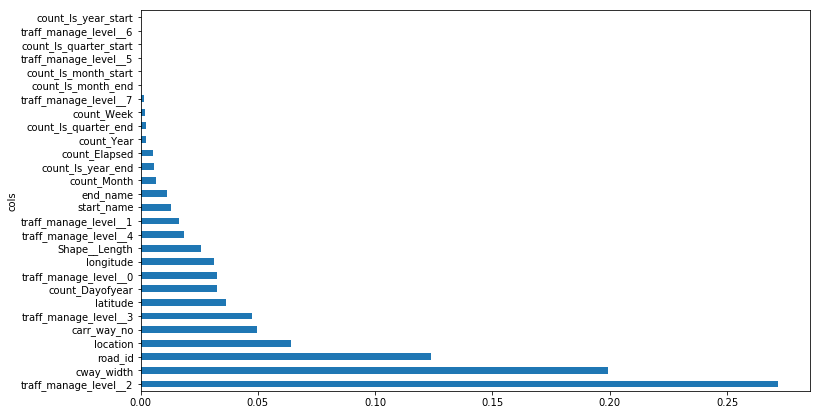

In [20]:
fi = rf_feat_importance(m, X_train)
plot_fi(fi)

Got a much better results once road info are added into the model (compared to the first model building attempt in the other notebook)

In [21]:
m = RandomForestRegressor(n_estimators=300, max_depth=28, max_features=0.5, oob_score= True, random_state=1, n_jobs  = -1)
def get_list_of_split_dates(df, start_date = '2017-01-01', test_months = 2):
    d = pd.to_datetime(start_date)
    last_date = df.count_date.max()
    test_ub = d + relativedelta(months = test_months)
    list_of_split_dates = [d]
    while test_ub < last_date:  
        list_of_split_dates.append(test_ub)
        test_ub += relativedelta(months = test_months)
    return list_of_split_dates

def back_testing(df, xcols, ycol, list_of_split_dates, test_months = 2):
    results = []
    for split_date in list_of_split_dates:
        X_train, X_test, y_train, y_test = expanding_window_split(df, xcols, ycol, split_date = split_date, test_months = test_months)
        m.fit(X_train, y_train)
        r = get_scores(m, X_train, X_test, y_train, y_test)
        results.append(r)
    return np.vstack(results)


In [22]:
list_of_split_dates = get_list_of_split_dates(df, start_date =  '2017-01-01', test_months = 2)
print(list_of_split_dates)
results = back_testing(df, xcols, ycol, list_of_split_dates, test_months = 2)
results  # rmse_train rmse_test, r2_train, r2_test, oob
results.mean(axis = 0)

[Timestamp('2017-01-01 00:00:00'), Timestamp('2017-03-01 00:00:00'), Timestamp('2017-05-01 00:00:00'), Timestamp('2017-07-01 00:00:00'), Timestamp('2017-09-01 00:00:00'), Timestamp('2017-11-01 00:00:00'), Timestamp('2018-01-01 00:00:00'), Timestamp('2018-03-01 00:00:00'), Timestamp('2018-05-01 00:00:00'), Timestamp('2018-07-01 00:00:00'), Timestamp('2018-09-01 00:00:00'), Timestamp('2018-11-01 00:00:00'), Timestamp('2019-01-01 00:00:00'), Timestamp('2019-03-01 00:00:00')]


array([[8.22877468e+02, 2.08510159e+03, 9.96926026e-01, 9.41559829e-01,
        9.77336602e-01],
       [8.18611094e+02, 3.00234621e+03, 9.96922549e-01, 8.97705065e-01,
        9.77374914e-01],
       [8.15963954e+02, 3.77634032e+03, 9.96901052e-01, 8.69469225e-01,
        9.77225519e-01],
       [8.16997179e+02, 2.41211920e+03, 9.96857407e-01, 9.09550947e-01,
        9.76978912e-01],
       [8.13895842e+02, 2.92087190e+03, 9.96827514e-01, 8.84511478e-01,
        9.76758605e-01],
       [8.11658871e+02, 3.09021960e+03, 9.96797287e-01, 8.69620949e-01,
        9.76527877e-01],
       [8.10444309e+02, 2.35029104e+03, 9.96755384e-01, 8.96527154e-01,
        9.76277528e-01],
       [8.06797246e+02, 3.03755994e+03, 9.96742738e-01, 8.33012545e-01,
        9.76213034e-01],
       [8.05521133e+02, 4.29219408e+03, 9.96688354e-01, 7.83049473e-01,
        9.75808188e-01],
       [8.30785881e+02, 2.76667774e+03, 9.96407626e-01, 8.83665177e-01,
        9.73954455e-01],
       [8.27034107e+02, 3.0641

array([8.18168170e+02, 2.79326966e+03, 9.96659430e-01, 8.68554936e-01,
       9.75607373e-01])

### Drop less impoartant variables: trial-and-error with the cut-off values

In [24]:
to_keep = fi[fi.imp>0.001].cols
results = back_testing(df, to_keep, ycol, list_of_split_dates, test_months = 2)
results.mean(axis = 0)

array([8.10691384e+02, 2.77940241e+03, 9.96719907e-01, 8.65571770e-01,
       9.76022952e-01])

In [25]:
to_keep = fi[fi.imp>0.0001].cols
results = back_testing(df, to_keep, ycol, list_of_split_dates, test_months = 2)
results.mean(axis = 0)

array([8.19536312e+02, 2.81264084e+03, 9.96648337e-01, 8.65506557e-01,
       9.75517540e-01])

In [63]:
# drop the least important variable
to_keep = fi.cols[:-1]
results = back_testing(df, to_keep, ycol, list_of_split_dates, test_months = 2)
results.mean(axis = 0)

array([8.18712064e+02, 2.80517868e+03, 9.96654554e-01, 8.65320130e-01,
       9.75559637e-01])

Dropping less important variables does not increase the validation score (but increase the oob score slightly).

###  Use dendrogram to see highly correlated features and try drop them

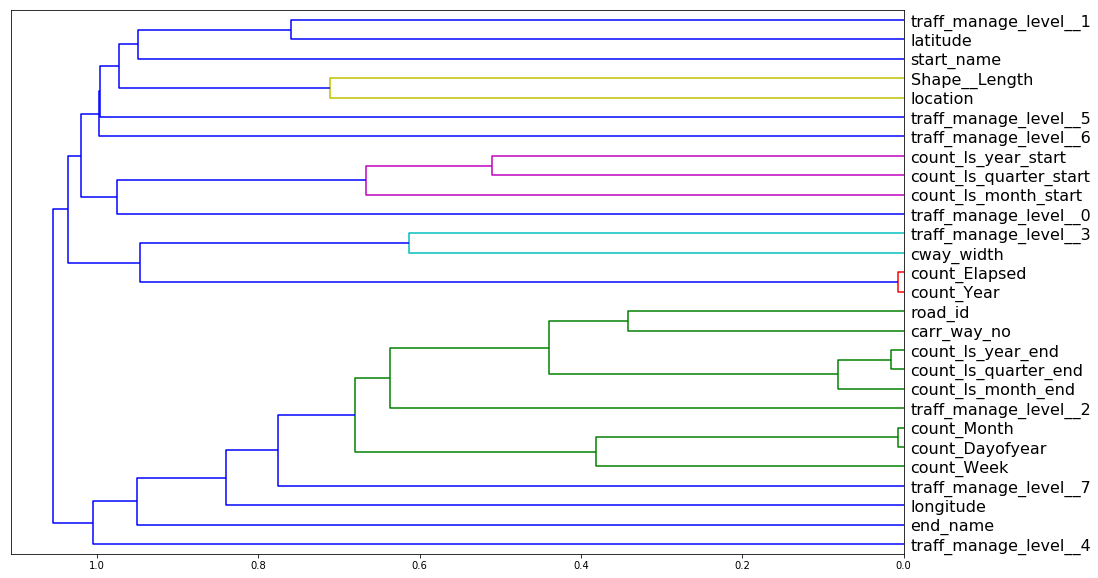

In [29]:
from scipy.cluster import hierarchy as hc
corr = np.round(df[xcols].corr('spearman'), 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df[xcols].columns, 
      orientation='left', leaf_font_size=16)
plt.show()

In [54]:
# select one of the highly correlated variables to drop
for c in ['count_Month', 'count_Is_year_end', 'count_Year']:
    to_keep = xcols.copy()
    to_keep.remove(c)
    results = back_testing(df, to_keep, ycol, list_of_split_dates, test_months = 2)
    print(c, results.mean(axis = 0))

count_Month [8.19146776e+02 2.81200179e+03 9.96651050e-01 8.63524129e-01
 9.75539070e-01]
count_Is_year_end [8.18974013e+02 2.82785564e+03 9.96652287e-01 8.62339958e-01
 9.75545393e-01]
count_Year [8.19236690e+02 2.79675358e+03 9.96650560e-01 8.65640442e-01
 9.75544019e-01]


It Seems like removing any of the variables would not improve the validation score.

In [72]:
# cross validate model performance
def train_test_split(df, xcols, ycol, train_size_f = 0.75, shuffle_bool = False, random_state = 121):
    train_size = int(df.shape[0] * train_size_f)
    if shuffle_bool:
        df_model = shuffle(df, random_state = 121)
    else:
        df_model = df.copy()
    X, y = df_model[xcols], df_model[ycol]
    X_train, X_test = split_vals(X, train_size)
    y_train, y_test = split_vals(y, train_size)
    return X_train, X_test, y_train, y_test


In [61]:
m = RandomForestRegressor(n_estimators=300, max_depth=28, max_features=0.5, oob_score= True, random_state=1, n_jobs  = -1)
X_train, X_test, y_train, y_test = train_test_split(df, xcols, ycol, shuffle_bool=True)
m.fit(X_train, y_train)
r = get_scores(m, X_train, X_test, y_train, y_test)
r

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=28,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=True, random_state=1, verbose=0, warm_start=False)

[905.3409872962602,
 2521.551451902568,
 0.9956492359464827,
 0.9634998495512624,
 0.9684131170130733]

# Analysis

In [62]:
# train on the full dataset
m.fit(df[xcols], df[ycol])
m.oob_score_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=28,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=True, random_state=1, verbose=0, warm_start=False)

0.9733131324337464

In [63]:
# save model
with open(r'data\final_model.sav','wb') as f:
    pickle.dump(m, f)

In [64]:
# load model
with open(r'data\final_model.sav','rb') as f:
    m = pickle.load(f)

### Traffic manage level
By adding the "traffic manage level" variables into the model, the r2 score increased from around 70 to around 90. Obviously it is an important variable, as also shown in the feature importance plot. 

In [71]:
# check the original labels
tml = label_encoders_dict['traff_manage_level'].inverse_transform([0,1,2,3,4,5,6,7])
for ind, val in enumerate(tml):
    print(ind, val)


0 < 10,000 vpd Rural/<15,000 vpd Urban
1 <500 vpd (Low Volume)
2 >= 10,000 vpd Rural/>=15,000 vpd Urban
3 >= 15,000 vpd Urban road, low speed
4 >=10,000 vpd & high speed
5 Low volume < 250 vpd with low risk
6 State Highway
7 Unknown


Check target distribution through feature 'traff_manage_level'

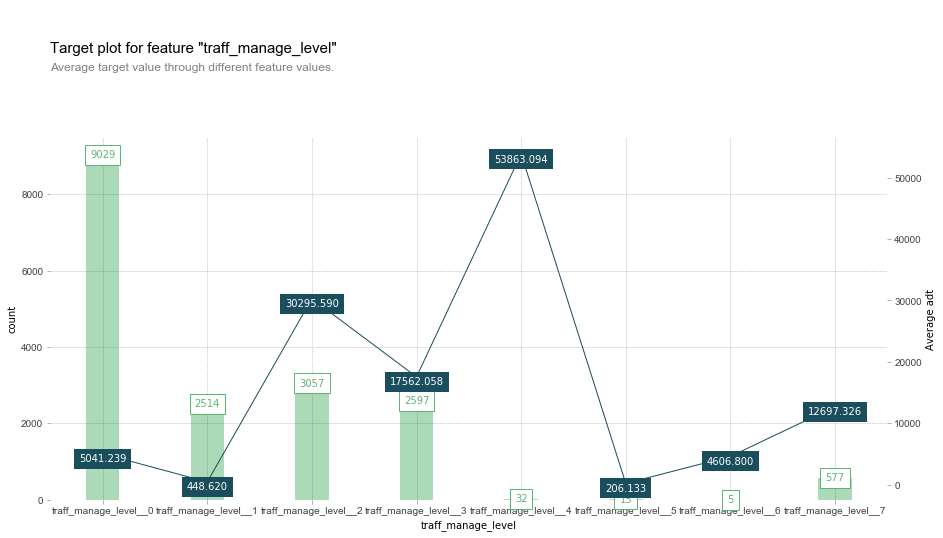

In [66]:
fig, axes, summery_df = info_plots.target_plot(
    df = df, feature = ['traff_manage_level__0',
       'traff_manage_level__1', 'traff_manage_level__2',
       'traff_manage_level__3', 'traff_manage_level__4',
       'traff_manage_level__5', 'traff_manage_level__6',
       'traff_manage_level__7'], feature_name = 'traff_manage_level',
        target = ycol
)

In [72]:
summery_df['description'] = tml
summery_df

,x,display_column,count,adt,description
0,0,traff_manage_level__0,9029,5041.238786,"< 10,000 vpd Rural/<15,000 vpd Urban"
1,1,traff_manage_level__1,2514,448.619730,<500 vpd (Low Volume)
2,2,traff_manage_level__2,3057,30295.589794,">= 10,000 vpd Rural/>=15,000 vpd Urban"
3,3,traff_manage_level__3,2597,17562.058144,">= 15,000 vpd Urban road, low speed"
4,4,traff_manage_level__4,32,53863.093750,">=10,000 vpd & high speed"
5,5,traff_manage_level__5,15,206.133333,Low volume < 250 vpd with low risk
6,6,traff_manage_level__6,5,4606.800000,State Highway
7,7,traff_manage_level__7,577,12697.325823,Unknown


The average traffic count value matches the describtion, but there are exceptions..

In [95]:
#for example, there are 900 exceptions for traff_manage_level__3
((df.adt < 15000) & (df.traff_manage_level__3 == 1)).sum()
# 

900

### Change of adt over time (years)

In [101]:
m = RandomForestRegressor(n_estimators=300, max_depth=28, max_features=0.5, oob_score= True, random_state=113, n_jobs  = -1)
xcols2 = xcols.copy()
xcols2.remove('count_Elapsed')  # remove count_Elapsed to better capture the effects of time
X_train, X_test, y_train, y_test = train_test_split(df, xcols2, ycol, shuffle_bool=True)
m.fit(X_train, y_train)
r = get_scores(m, X_train, X_test, y_train, y_test)
r

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=28,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=True, random_state=113, verbose=0, warm_start=False)

[909.6476567514751,
 2309.7753460462845,
 0.9955058590066901,
 0.9714677871819497,
 0.9672318708450173]

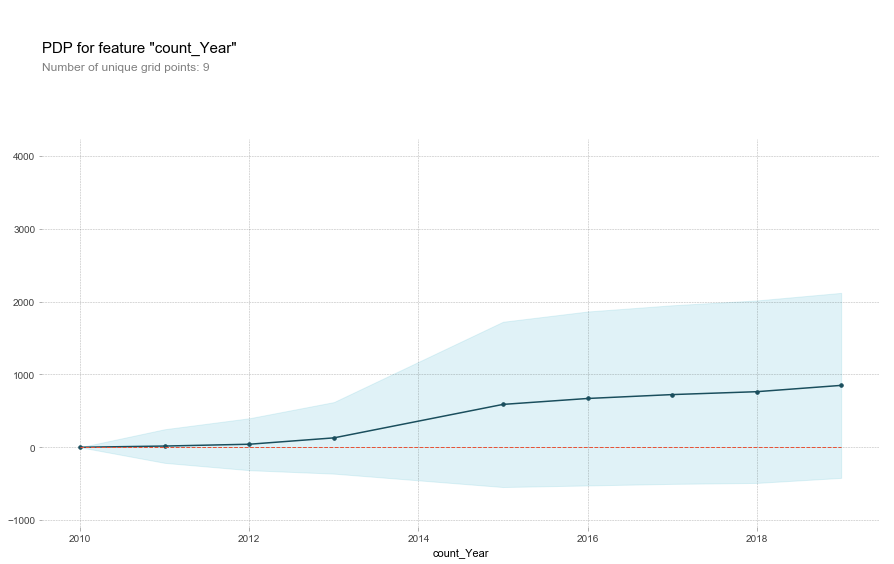

In [58]:
pdp_year = pdp.pdp_isolate(
    model=m, dataset=df[xcols2], model_features=xcols2, feature='count_Year'
)
fig, axes = pdp.pdp_plot(pdp_year, 'count_Year')


In [28]:
fig.savefig(r'images/pdp_plot.png')